In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numba import jit
np.set_printoptions(suppress=True)

In [3]:
mu = np.array([0.3785, 0.2793, -0.0923, 0.6639, 0.9141])
cov = np.array([
        [1.9776, 1.1421, 0.7820, 2.9788, 2.5520],
        [1.1421, 1.9370, -0.2421, 0.7157, 1.3348],
        [0.7820, -0.2421, 11.6847, 2.7199, 1.5728],
        [2.9788, 0.7157, 2.7199, 16.9808, 10.7832],
        [2.5520, 1.3348, 1.5728, 10.7832, 9.9854]
])
ar = np.array([0.1938,0.0660,-0.0323,-0.0279,-0.1354])

We have a model that follows an ar-process:

$$ R_t = \mu + A R_{t-1} + \sqrt{\Omega} \varepsilon, \quad \varepsilon = \begin{pmatrix} \varepsilon^{(1)} & 0 \\ 0 & \varepsilon^{(2)}\end{pmatrix}, \quad \varepsilon^{(i)} \sim \text{iid}\mathbf{N}(0,1), \quad i = 1, 2 $$

where $A$ is a diagonal matrix of AR coefficients, and $\Omega$ is a covariance matrix. All parameters are assumed time invariant.

We now generate 5 random numbers to initiate a process, which we plot thereafter

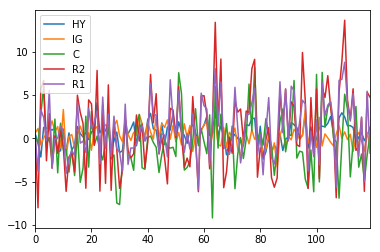

In [7]:
A = len(mu)  # no. of assets
R0 = np.random.random(A)  # First returns
T = 120  # investment horizon

ret = np.zeros((A,T))
ret[:,0] = R0
for t in range(T-1):
    mean = mu + ar*ret[:,t]
    ret[:,t+1] = np.random.multivariate_normal(mean,cov)

ret = pd.DataFrame(ret.T, columns = ['HY','IG','C','R2','R1'])

ret.plot()

If instead we'd like to do a hidden Markow model (HMM), we will need a transition matrix to generate hidden state paths, and switching parameters.

In [107]:
mu = np.array([
    [0.3785, 0.2000],
    [0.2793, 0.4405],
    [-0.0923, -0.1077],
    [0.6639, -0.3688],
    [0.9141, -0.5641]
])

ar = np.array([
    [0.1938, 0.2824],
    [0.0660, -0.0677],
    [-0.0323, 0.1546],
    [-0.0279, -0.0099],
    [-0.1354, -0.0072]
])

cov = np.array([
    [
        [1.9776, 1.1421, 0.7820, 2.9788, 2.5520],
        [1.1421, 1.9370, -0.2421, 0.7157, 1.3348],
        [0.7820, -0.2421, 11.6847, 2.7199, 1.5728],
        [2.9788, 0.7157, 2.7199, 16.9808, 10.7832],
        [2.5520, 1.3348, 1.5728, 10.7832, 9.9854]
    ],
    [
        [25.3408, 8.0008, 2.2317, 28.9156, 19.9385],
        [8.0008, 5.0525, 1.2737, 5.9491, 4.2906],
        [2.2317, 1.2737, 33.8081, 7.2009, 6.1226],
        [28.9156, 5.9491, 7.2009, 79.9800, 51.4189],
        [19.9385, 4.2906, 6.1226, 51.4189, 42.9327]
    ]
])

probs = np.array([
    [0.97, 0.12],
    [0.03, 0.88]
])

In [80]:
print('State 1: pos. semi. def?: ', np.all(np.linalg.eigvals(cov[0])>0))
print('State 2: pos. semi. def?: ', np.all(np.linalg.eigvals(cov[1])>0))

print('State 1: symmetric?: ', np.allclose(cov[0],cov[0].T))
print('State 1: symmetric?: ', np.allclose(cov[1],cov[1].T))

State 1: pos. semi. def?:  True
State 2: pos. semi. def?:  True
State 1: symmetric?:  True
State 1: symmetric?:  True


The moments above and the switching parameters should allow us to generate state paths.

It is the transition matrix below, which regulates the probability of switching states:

$$ P = 
\begin{pmatrix}
    p_11 & 1 - p_22 \\
    1 - p_11 & p_22
\end{pmatrix}.
$$

That is, $p_ij$ is the probability of transitioning from state $i$ to $j$, e.g. from state 1 to 2 when $p_ij = p_12$.

To simulate the state path, we can draw some random uniform numbers on the interval $[0,1]$, and conditional on the state we are arriving from, transition if the random number is larger than the "remain" value, and stay if it is not.

We want to solve this dynamically. To see how we can manipulate the probability matrix dynamically, er have the following experiment:

In [15]:
print(np.sum(probs[:0,0]))
print(np.sum(probs[:1,0]))
print(np.sum(probs[:2,0]))
print(np.sum(probs[:0,1]))
print(np.sum(probs[:1,1]))
print(np.sum(probs[:2,1]))

0.0
0.97
1.0
0.0
0.12
1.0


The above tells us that if `np.sum(probs[:0,0]) < u[t] <= np.sum(probs[:1,0])` then the random number is $u\in (0,97]$, which tells us that we are staying in state 1.

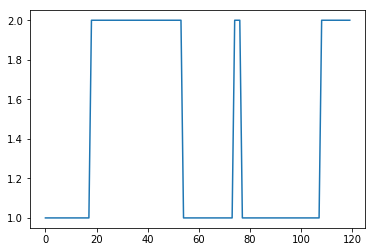

In [66]:
np.random.seed(876)
u = np.random.uniform(size=T)  # Random numbers that determine transition
S = mu.shape[1]  # number of states
start = 1  # Starting state. Can be used as an input into a function

@jit(nopython=True)
def sim_state(start, S, u, T):
    state = np.ones(S)  # Auxiliary one-period state container
    state_path = np.ones(T)  # The state path

    for t in range(T-1):
        i = int(state_path[t]-1)  # index of state we are arriving from
        for s in range(S):
            state[s] = (s+1) * (np.sum(probs[:s,i]) < u[t] <= np.sum(probs[:s+1, i]))
        state_path[t+1] = np.sum(state)
    return state_path

state_path = sim_state(start, S, u, T)

plt.plot(state_path)
plt.show()

So now we have that we sometimes transition, sometimes do not. The states are quite persistent, with a single peak for state 2 as the exception.

Every time we are in state 1, we e.g. use the first set of mu's, and use the 2nd in the periods where we are in state 2. This is true for all our parameters.

Consequently, we can now generate multivariate, state-dependent AR(1) returns.

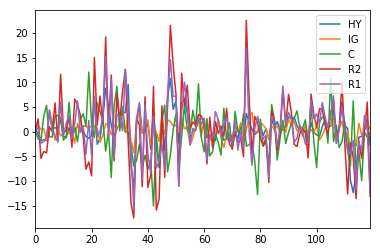

In [91]:
A = len(mu)  # no. of assets
R0 = np.random.random(A)  # First returns
T = 120  # investment horizon

np.random.seed(12345)
ret = np.zeros((A,T))
ret[:,0] = R0
for t in range(T-1):
    s = int(state_path[t]-1)  # Current state (by index)
    mean = mu[:,s] + ar[:,s]*ret[:,t]
    ret[:,t+1] = np.random.multivariate_normal(mean,cov[s])

ret_ar = pd.DataFrame(ret.T, columns = ['HY','IG','C','R2','R1'])

ret_ar.plot()

There is now clear state-shifting. A period of high volatility between months 20-ish to 55-ish, around month 70-75 and again from around 105 and forward.

The level is harder to gather, as there are AR(1) components, but it does seem that a regime-shift to state 2 initiates a movement away from a stable mean, albeit the movement is downwards in the first and final case, and seemingly upwards in the second, which is possible explained by the AR-component.

If we instead simulate a simple, non-AR model, we ought to see something differet.

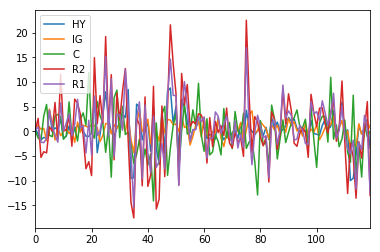

In [93]:
A = len(mu)  # no. of assets
R0 = np.random.random(A)  # First returns
T = 120  # investment horizon

np.random.seed(12345)
ret = np.zeros((A,T))
ret[:,0] = R0
for t in range(T-1):
    s = int(state_path[t]-1)  # Current state (by index)
    mean = mu[:,s]
    ret[:,t+1] = np.random.multivariate_normal(mean,cov[s])

ret = pd.DataFrame(ret.T, columns = ['HY','IG','C','R2','R1'])

ret.plot()

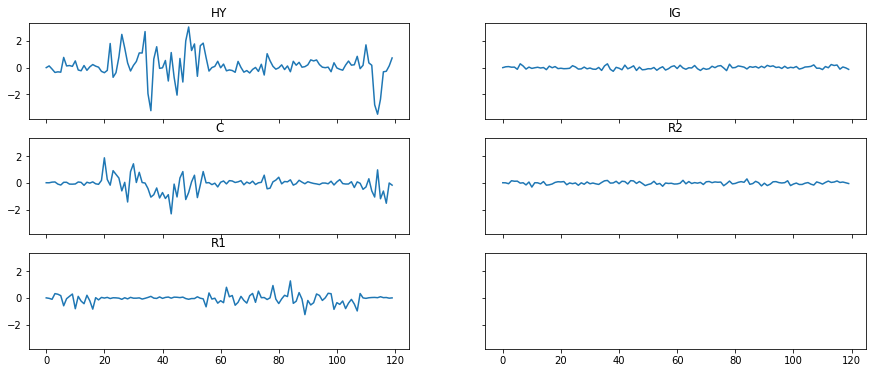

In [101]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(15,6))
labels = ret.columns

for ax, l in zip(axes.flat, labels):
    ax.plot(ret_ar[l]-ret[l])
    ax.set_title(l)
plt.show()

From the above, we would have an idea that for HY and C the AR(1) coefficients are largest in state 2, whereas they are smallest in state 2 for R1. For IG and R2 there seems to be no difference.

To illustrate whether this is true, we use seaborn that provides us with a heatmap over the relative values of the AR coefficients.

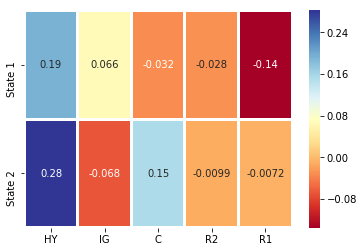

In [104]:
import seaborn as sns
sns.heatmap(pd.DataFrame(ar.T,index=['State 1','State 2'], columns = labels), annot=True, cmap='RdYlBu', linewidth=2)

What we have observed in the difference-plots above is true. Autocorrelation is numerically stronger in state 2 for asset classes 'HY', 'C', numerically strongest in state 1 for 'R1', and weak in both states for asset classes 'IG' and 'R2'.

In [115]:
test = False
not test

True